In [32]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("./data"))
# Any results you write to the current directory are saved as output.

import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

['gender_submission.csv', 'test.csv', 'train.csv']


**Get Data**

In [33]:
test_df = pd.read_csv('./data/test.csv')
train_df = pd.read_csv('./data/train.csv')
combine = [train_df, test_df]
train_df.shape, test_df.shape

((891, 12), (418, 11))

In [34]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [35]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [36]:
train_df.columns.values

array(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object)

In [37]:
train_df.isnull().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

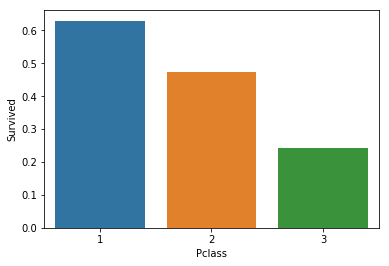

In [38]:
pclass_survived = train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean()
sns.barplot('Pclass', 'Survived', data = pclass_survived)

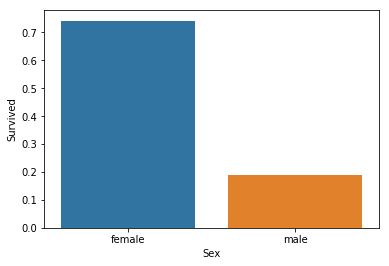

In [39]:
sex_survive = train_df[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean()
sns.barplot('Sex', 'Survived', data = sex_survive)

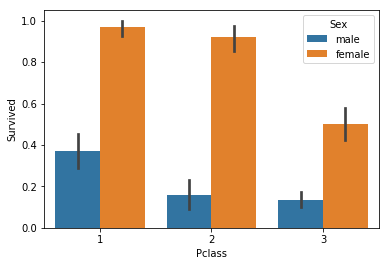

In [40]:
sns.barplot('Pclass', 'Survived', hue='Sex', data = train_df)

**Clean Data**

In [41]:
train_df = train_df.drop(['Ticket', 'Cabin', 'PassengerId'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_df, test_df]
train_df.shape, test_df.shape

((891, 9), (418, 9))

**Prepare Data**

In [42]:
sex_mapping = {"male": 0, "female": 1}
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map(sex_mapping)
    dataset['Sex'] = dataset['Sex'].fillna(0)

train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,53.1000,S
4,0,3,"Allen, Mr. William Henry",0,35.0,0,0,8.0500,S


In [43]:
for dataset in combine:
    dataset['Age'] = dataset['Age'].replace(np.nan, dataset['Age'].mean(), regex=True)
    dataset['Age'] = dataset['Age'].astype(int)

train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",0,22,1,0,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38,1,0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",1,26,0,0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35,1,0,53.1000,S
4,0,3,"Allen, Mr. William Henry",0,35,0,0,8.0500,S


In [44]:
train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.344762
2,"(32.0, 48.0]",0.403226
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


In [45]:
for dataset in combine:    
    dataset.loc[dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']
    
train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",0,1,1,0,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,2,1,0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",1,1,0,0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,2,1,0,53.1000,S
4,0,3,"Allen, Mr. William Henry",0,2,0,0,8.0500,S


In [46]:
frequence_port = train_df.Embarked.dropna().mode()[0]

'''
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].replace(np.nan, "M", regex=True)
'''
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(frequence_port)
    
train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean()

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


In [47]:
#embark_mapping = {"S": 0, "C": 1, "Q": 2, "M": 3}

embark_mapping = {"S": 0, "C": 1, "Q": 2}
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map(embark_mapping).astype(int)

train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",0,1,1,0,7.2500,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,2,1,0,71.2833,1
2,1,3,"Heikkinen, Miss. Laina",1,1,0,0,7.9250,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,2,1,0,53.1000,0
4,0,3,"Allen, Mr. William Henry",0,2,0,0,8.0500,0


In [48]:
test_df.isnull().any()

PassengerId    False
Pclass         False
Name           False
Sex            False
Age            False
SibSp          False
Parch          False
Fare            True
Embarked       False
dtype: bool

In [49]:
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,"Kelly, Mr. James",0,2,0,0,7.8292,2
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,2,1,0,7.0000,0
2,894,2,"Myles, Mr. Thomas Francis",0,3,0,0,9.6875,2
3,895,3,"Wirz, Mr. Albert",0,1,0,0,8.6625,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,1,1,1,12.2875,0


In [50]:
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean()

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [51]:
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train_df = train_df.drop(['FareBand'], axis=1)
combine = [train_df, test_df]
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",0,1,1,0,0,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,2,1,0,3,1
2,1,3,"Heikkinen, Miss. Laina",1,1,0,0,1,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,2,1,0,3,0
4,0,3,"Allen, Mr. William Henry",0,2,0,0,1,0


In [52]:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,0,1
Title,,
Capt,1,0
Col,2,0
Countess,0,1
Don,1,0
Dr,6,1
Jonkheer,1,0
Lady,0,1
Major,2,0
Master,40,0


In [53]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


In [54]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,"Braund, Mr. Owen Harris",0,1,1,0,0,0,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,2,1,0,3,1,3
2,1,3,"Heikkinen, Miss. Laina",1,1,0,0,1,0,2
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,2,1,0,3,0,3
4,0,3,"Allen, Mr. William Henry",0,2,0,0,1,0,1


In [55]:
test_df.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,892,3,"Kelly, Mr. James",0,2,0,0,0,2,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,2,1,0,0,0,3
2,894,2,"Myles, Mr. Thomas Francis",0,3,0,0,1,2,1
3,895,3,"Wirz, Mr. Albert",0,1,0,0,1,0,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,1,1,1,1,0,3
5,897,3,"Svensson, Mr. Johan Cervin",0,0,0,0,1,0,1
6,898,3,"Connolly, Miss. Kate",1,1,0,0,0,2,2
7,899,2,"Caldwell, Mr. Albert Francis",0,1,1,1,2,0,1
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",1,1,0,0,0,1,3
9,901,3,"Davies, Mr. John Samuel",0,1,2,0,2,0,1


In [56]:
train_df.head(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,"Braund, Mr. Owen Harris",0,1,1,0,0,0,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,2,1,0,3,1,3
2,1,3,"Heikkinen, Miss. Laina",1,1,0,0,1,0,2
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,2,1,0,3,0,3
4,0,3,"Allen, Mr. William Henry",0,2,0,0,1,0,1
5,0,3,"Moran, Mr. James",0,1,0,0,1,2,1
6,0,1,"McCarthy, Mr. Timothy J",0,3,0,0,3,0,1
7,0,3,"Palsson, Master. Gosta Leonard",0,0,3,1,2,0,4
8,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",1,1,0,2,1,0,3
9,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",1,0,1,0,2,1,3


In [57]:
predict_train = train_df.drop(["Survived", "Name"], axis=1)
predict_test = test_df.drop(["PassengerId", "Name"], axis=1)
X_train = predict_train
Y_train = train_df["Survived"]
X_test  = predict_test
X_train.shape, Y_train.shape, X_test.shape

((891, 8), (891,), (418, 8))

In [58]:
X_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,3,0,2,0,0,0,2,1
1,3,1,2,1,0,0,0,3
2,2,0,3,0,0,1,2,1
3,3,0,1,0,0,1,0,1
4,3,1,1,1,1,1,0,3


**Train Model**

In [59]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_dct_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

89.34

In [60]:
knn = KNeighborsClassifier()
knn.fit(X_train, Y_train)
Y_knn_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

85.97

In [61]:
rf = RandomForestClassifier()
rf.fit(X_train, Y_train)
Y_rf_pred = rf.predict(X_test)
acc_rf = round(rf.score(X_train, Y_train) * 100, 2)
acc_rf

88.55

**Test Data**

In [62]:
submission = pd.read_csv('./data/gender_submission.csv')
temp = pd.DataFrame({"0-PassengerId": test_df["PassengerId"], 
                     "1-Submission": submission['Survived'], 
                     "2-DecissionTree": Y_dct_pred,
                     "3-KNN": Y_knn_pred,
                     "4-RandomForest": Y_rf_pred
                    })
temp.head(20)

,0-PassengerId,1-Submission,2-DecissionTree,3-KNN,4-RandomForest
0,892,0,0,0,0
1,893,1,0,0,0
2,894,0,0,0,0
3,895,0,0,0,0
4,896,1,0,0,0
5,897,0,0,0,0
6,898,1,1,1,1
7,899,0,0,0,0
8,900,1,1,1,1
9,901,0,0,0,0


**Improve**

1. fill embarked with mean
2. cut title from name
3. add train model randomforest